In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


#-----------------------------------------------------------------------------------------------------------

imageslist = []
import os
if os.path.exists("image_file_name.txt") == False:
    with open("image_file_name.txt","w") as f:
        f.write("image_file_name")

if os.path.exists("image_file_name.txt") == True:
    with open("image_file_name.txt","r") as f:
        for line in f:
            line = line.strip()
            if line != "image_file_name":
                if os.path.exists(line) == True:
                    imageslist.append(str(line.strip()))
                else:
                    print(f'image_file : "{line}" は存在しません。')


#-----------------------------------------------------------------------------------------------------------

def removal_background(color_image,RGB,kyoyou): #写真のNumPy配列を渡すと戻り値として背景を１とし、それ以外を0に置き換えた配列が戻ってくる。
    background_color = np.array(RGB)

    code0list = np.ones((color_image.shape[0]*color_image.shape[1],1), dtype='i1') #一旦0で埋める

    sa = np.abs(background_color - color_image)
    sa = sa.reshape(color_image.shape[0]*color_image.shape[1],3) #1ピクセル毎に背景色RGBと写真のRGBの差の絶対値の集合値を算出する為、配列を縦一列、列数３にする。
    text = np.array(np.where((np.sum(sa,axis=1)) > kyoyou)[0]) #背景色判定の許容値を超えた場合文字判定。

    code0list[text, 0] = np.array(0) #code0listに文字判定の場所を再代入。
    code0list = code0list.reshape(color_image.shape[0],color_image.shape[1]) #写真の比率にリサイズ。

    return code0list


def image_removal_background(imagename,RGB,kyoyou):
    #image = Image.open(imagename)
    image = cv2.cvtColor(cv2.imread(imagename),cv2.COLOR_BGR2RGB)
    color_image = np.array(image)
    background_color = np.array(RGB)
    print(background_color)

    dataslist = {}
    dataslist["image"] = image
    dataslist["RGB"] = RGB
    dataslist["kyoyou"] = kyoyou

    code0list = removal_background(color_image,RGB,kyoyou)


    with open("coode0list_printfile.txt","w") as f:
        for y in range(code0list.shape[0]):
            txt = ""
            for x in range(code0list.shape[1]):
                txt = txt + str(code0list[y,x])
            f.write(txt + "\n")
        else:
            print(code0list.shape)

    dataslist["code0list"] = code0list

    return dataslist


#-----------------------------------------------------------------------------------------------------------

import copy

def seach_txtposition(dataslist, Airauto):
    code0list = dataslist["code0list"]
    xlen = code0list.shape[1]

    seach = "background"
    txt_sfy = []

    for y in range(int(code0list.shape[0])):

        if np.sum(code0list[y,:]) != xlen:
            if seach == "background":
                seach = "txt"
                txt_sfy.append([y, ""])

        else:
            if seach == "txt":
                seach = "background"
                txt_sfy[-1][1] = y-1

    seach = "background"
    linetxts_sfyx = []
    Airlist = []
    Airnum,Aircount,txtlen = 0,0,0
    #Aircount,deviation = 1,0

    for line in range(len(txt_sfy)):
        txt_sfyx = []

        for x in range(int(code0list.shape[1])):

            if np.sum(code0list[txt_sfy[line][0]:txt_sfy[line][1],x]) != txt_sfy[line][1]-txt_sfy[line][0]:
                if seach == "background":
                    seach = "txt"
                    txt_sfyx.append( [x , ""] )

            else:
                if seach == "txt":
                    seach = "background"
                    txt_sfyx[-1][1] = x-1

                    if Airauto == "auto":
                        if len(txt_sfyx) >= 2:
                            if abs(Airnum - (txt_sfyx[-1][0] - txt_sfyx[-2][1])) <= 1:
                                if Aircount >= 3:
                                    Airlist.append(txtlen)
                                Aircount += 1
                            else:
                                Airnum = txt_sfyx[-1][0] - txt_sfyx[-2][1]
                                txtlen = txt_sfyx[-1][1] - txt_sfyx[-2][1]
                                Aircount,deviation = 1,0


        linetxts_sfyx.append([txt_sfy[line],txt_sfyx])

    Airlinetxts_sfyx = copy.deepcopy(linetxts_sfyx)

    if Airauto == "auto":
        Airlen = int(sum(Airlist)/len(Airlist))
        print(Airlist,Airlen)
    else:
        Airlen = Airauto

    for line in range(len(linetxts_sfyx)):
        count = 0
        for txtline in range(len(linetxts_sfyx[line][1])-1):
            if linetxts_sfyx[line][1][txtline+1][0] - linetxts_sfyx[line][1][txtline][1] > Airlen:

                Airlinetxts_sfyx[line][1].insert(txtline + count + 1,"Air")
                count += 1

    dataslist["linetxts_sfyx"] = Airlinetxts_sfyx
    return dataslist


#-----------------------------------------------------------------------------------------------------------

def readtxt_imshow(dataslist):
    color_image = np.array(dataslist['image'])
    linetxts_sfyx = dataslist["linetxts_sfyx"]

    for line in linetxts_sfyx:
        a = line[0][0]
        b = line[0][1]
        color_image[a,:] = np.array([0,150,150])
        color_image[b,:] = np.array([0,150,150])
        for txt in range(len(line[1])):
            if line[1][txt] != "Air":
                color_image[a:b,line[1][txt][1]] = np.array([0,150,0])
                color_image[a:b,line[1][txt][0]] = np.array([0,150,0])
            else:
                color_image[a:b,line[1][txt-1][1]+5] = np.array([255,0,0])
                color_image[a:b,line[1][txt+1][0]-5] = np.array([255,0,0])

    return color_image


#-----------------------------------------------------------------------------------------------------------

def txtdatas_insert(dataslist):
    color_image = np.array(dataslist["image"])
    code0list = dataslist["code0list"]

    #plt.imshow(color_image[:100,:100])
    linetxts_sfyx = dataslist["linetxts_sfyx"]
    Alltxtimages,txtimages = [],[]
    Alltxtdatas,txtdatas = [],[]


    for line in range(len(linetxts_sfyx)):
        placey = linetxts_sfyx[line][0]
        for txt in range(len(linetxts_sfyx[line][1])):
            if linetxts_sfyx[line][1][txt] != "Air":

                placex = linetxts_sfyx[line][1][txt]
                leny = placey[1] - placey[0]
                lenx = placex[1] - placex[0]

                txtimage = color_image[placey[0]:placey[1],placex[0]:placex[1]]
                txtdata = code0list[placey[0]:placey[1],placex[0]:placex[1]]

                for top in range(leny):
                    if np.sum(txtdata[top,:]) != lenx:
                        txtimage = txtimage[top:,:]
                        txtdata = txtdata[top:,:]
                        break

                resizeleny = np.shape(txtdata)[0]

                for lower in range(resizeleny):
                    if np.sum(txtdata[resizeleny-lower -1 ,:]) != lenx:
                        txtimage = txtimage[:resizeleny-lower,:]
                        txtdata = txtdata[:resizeleny-lower,:]
                        break

            else:
                txtimage = ""
                txtdata = ""

            txtimages.append(txtimage)
            txtdatas.append(txtdata)

        Alltxtimages.append(txtimages)
        Alltxtdatas.append(txtdatas)

        txtimages = []
        txtdatas = []

    dataslist["Alltxtimages"] = Alltxtimages
    dataslist["Alltxtdatas"] = Alltxtdatas
    return dataslist


#-----------------------------------------------------------------------------------------------------------

def print_textdatas(dataslist,writefilename):
    txtdatas = dataslist["Alltxtdatas"]
    lineMaxlenx,lineMaxleny = [],[]

#    with open(writefilename,"w") as f:

    Maxlenx = 0
    for line in range(len(txtdatas)):
        lineMaxleny.append(0)
        if len(txtdatas[line]) > Maxlenx:
            Maxlenx = len(txtdatas[line])
        txtline = txtdatas[line]
        for txt in range(len(txtline)):
            if len(txtline[txt]) != 0:
                if np.shape(txtline[txt])[0] > lineMaxleny[line]:
                    lineMaxleny[line] = np.shape(txtline[txt])[0]


    for nouse in range(Maxlenx):
        lineMaxlenx.append(0)

    for line in range(len(txtdatas)):
        txtline = txtdatas[line]
        for txt in range(len(txtline)):
            if len(txtline[txt]) != 0:
                if np.shape(txtline[txt])[1] > lineMaxlenx[txt]:
                    lineMaxlenx[txt] = np.shape(txtline[txt])[1]


    with open(writefilename,"w") as f:
        for line in range(len(txtdatas)):
            printlist = []
            txtline = txtdatas[line]
            thislineMaxY = lineMaxleny[line]

            for nouse in range(thislineMaxY):
                printlist.append("")

            for txt in range(len(txtline)):
                thislineMaxX = lineMaxlenx[txt]

                Textlen = thislineMaxX *2 +1

                if len(txtline[txt]) != 0:
                    ylen,xlen = np.shape(txtline[txt])
                    Airy = thislineMaxY - ylen
                    Airx = (thislineMaxX - xlen)*2

                    y = 0

                    for nouse in range(Airy//2 + Airy%2):
                        printlist[y] = (f"{printlist[y]}{Textlen * ' '} | ")
                        y += 1

                    for txty in txtline[txt]:
                        printlist[y] = (f"{printlist[y]}{(Airx//2 + Airx%2)*' '}{txty}{(Airx//2)*' '} | ")
                        y += 1
                    for nouse in range(Airy//2):
                        printlist[y] = (f"{printlist[y]}{Textlen * ' '} | ")
                        y += 1


                else:
                    y = 0
                    for nouse in range(thislineMaxY):
                        printlist[y] = (f"{printlist[y]}{Textlen * ' '} | ")
                        y += 1

            printlen = len(printlist[0][:894])

            if line != 0:
                b = printlen
                if a > b:
                    f.write(f"\n{a*'-'}\n\n")
                else:
                    f.write(f"\n{b*'-'}\n\n")
                a = printlen

            else:
                f.write(f"{printlen*'-'}\n\n")
                a = printlen
            

            for printline in printlist:
                f.write("| "+printline[:894]+ "\n")

        f.write(f"\n{len(printline[:894])*'-'}")


#-----------------------------------------------------------------------------------------------------------

for imagename in imageslist:

    if imageslist[0] == "/Users/matsuurakenshin/WorkSpace/development/txtreader/txtreader_Mk-II/textdata.jpeg":
        dataslist = image_removal_background(imagename,[36,36,36],180)
    else:
        dataslist = image_removal_background(imagename,[36,36,36],60)
        
    dataslist = seach_txtposition(dataslist,100)
    dataslist = txtdatas_insert(dataslist)

    print_textdatas(dataslist,"Alltextimages.text")
    txtimage = dataslist["Alltxtimages"]
    txtdata = dataslist["Alltxtdatas"]
    #plt.imshow(readtxt_imshow(dataslist))
    #plt.imshow(cv2.resize(txtimage[0][0],dsize=(10,30)))
    print(txtdata[0][1])
    print_textdatas(dataslist,"textdataslist_printfile.txt")



In [16]:
import pickle

"""
### pickleで保存（書き出し）
with open('data.pickle', mode='wb') as fo:
  pickle.dump(txtimage, fo)
"""

### pickleで保存したファイルを読み込み
with open('data.pickle', mode='br') as fi:
  txtimage = pickle.load(fi)

In [ ]:
plt.imshow(dataslist["image"])

In [176]:

def Myint(num): #数値の int部分を確実に表示させる様にする自作関数
    for line in range(len(str(num))):
        if str(num)[line] == ".":
            return int(str(num)[:line])
    return num


#数値の整列を行う関数

def SET_numbertxt(numberslist,mode):
    if mode == 0:
        Max = 0
        len_list = []

        for line in numberslist:
            len_list.append(len(line))
            if len(line) > Max:
                Max = len(line)
        
        New_list = []
        Line_list = []
        for nouse in range(Max):
            New_list.append("")

        for line in numberslist:
            Set_list = copy.deepcopy(New_list)

            for number in range(len(line)):
                Set_list[number] = line[number]
            
            Line_list.append(Set_list)
        
        Line_list = np.array(Line_list)

        search_list = []
        for num in range(np.shape(Line_list)[1]):
            search_list.append(Line_list[:,num])

        search_list = np.array(SET_numbertxt(search_list,1))
        Line_list = []

        for num in range(np.shape(search_list)[1]):
            Line_list.append(search_list[:,num])

        returndata = []
        for line in range (np.shape(Line_list)[0]):
            cut = len_list[line]
            returndata.append(Line_list[line][:cut])

        return returndata

    
    elif mode == 1:

        for line in range(len(numberslist)):
            Maxintlen,Maxfloatlen = 0,0

            for num in numberslist[line]:

                if len(str(Myint(num))) > Maxintlen:
                    Maxintlen = len(str(Myint(num)))

                if len(str(num)) - len(str(Myint(num))) > Maxfloatlen:
                    Maxfloatlen = len(str(num)) - len(str(Myint(num)))

            Maxlen = Maxintlen + Maxfloatlen

            for nowread in range(len(numberslist[line])):
                num = numberslist[line][nowread]
                Air0 = Maxintlen - len(str(Myint(num)))
                Air1 = Maxlen - (Air0 + len(str(num)))

                numberslist[line][nowread] = (Air0 * " ") + str(num) + (Air1 * " ")

        return numberslist#[:-1]



In [ ]:

seach_textdatas = []
set_txttype = ""
set_wariai = ""
seach_shape = [0,0]
set_txtdata = []
textdata = ""
seach_num = 0

with open("/Users/matsuurakenshin/WorkSpace/development/txtreader/txtreader_Mk-II/Seave_Txtdatas.txt","r") as f:
    for line in f:
        line = line.strip()
        if len(line) == 5 and line[-2:] == " ]":
            #print(line)
            set_txtdata = np.array(set_txtdata).reshape(seach_shape)
            seach_textdatas.append([set_wariai,seach_shape,np.where(set_txtdata==0),set_txttype])
            textdata = textdata + set_txttype
            set_txtdata = []
            set_txttype = line[2]
            seach_num = 1
        elif seach_num == 1:
            set_wariai = float(line)
            seach_num = 2
        elif seach_num == 2:
            for txt in range(len(line)):
                if line[txt] == ",":
                    seach_shape = [int(line[1:txt]),int(line[txt+2:-1])]
            seach_num = 3
        elif seach_num == 3:
            for txt in range(len(line)):
                if line[txt] == "0" or line[txt] == "1":
                    set_txtdata.append(int(line[txt]))

    set_txtdata = np.array(set_txtdata).reshape(seach_shape)
    seach_textdatas.append([set_wariai,np.shape(set_txtdata),np.where(set_txtdata==0),set_txttype])
    textdata = textdata + set_txttype

seach_textdatas = seach_textdatas[1:]

'''
testdata        が 文字
seach_textdatas が 文字コード
'''

#---------------------------------------------------------------------------------------------------------------

#類似・重なる字の調査用プログラム

def test_seach_txt(txtimage,seach_textdatas,kyoyou,dataslist,txt):
    #for txt in seach_textdatas[3]:
    resembletxt = []
    rgb = dataslist["RGB"]
    kyoyoucolor = dataslist["kyoyou"]
    hiritu = np.shape(txtimage)[1]/np.shape(txtimage)[0]
    for line in range(len(seach_textdatas)):

        if abs(seach_textdatas[line][0] - hiritu) < kyoyou:
            set_image = removal_background(cv2.resize(txtimage,dsize=(seach_textdatas[line][1][1],seach_textdatas[line][1][0])),rgb,kyoyoucolor)
            #print(set_image)
            syougouritu = np.count_nonzero(set_image[seach_textdatas[line][2]] == 0) / np.shape(seach_textdatas[line][2])[1]

            if txt != "None" and seach_textdatas[line][3] == txt:
                #print(set_image)

                print(f"\n ▶️ {txt} :{str(syougouritu * 100)}%\n")

            if syougouritu > 0.85:

                resembletxt.append(line)
                #resembletxt.append(seach_textdatas[line][3])
                
    return resembletxt


#識字用のコード配列が合っているかの確認

for i in range(len(seach_textdatas)):
    if seach_textdatas[i][3] != textdata[i]:
        print(i)


### pickleで保存したファイルを読み込み
with open('data.pickle', mode='br') as fi:
  seach_txtimage = pickle.load(fi)[0]

txtimages = []
line = 0

with open("testanser_printfile.txt", "w")as f:

    
    a = 0
    Truecount = 0
    Falsecount = 0

    retest = [[[]],[]]
    num = []
    txtnum = []


    for txt in range(len(seach_textdatas)):
        num.append(txt)
        txtnum.append([])
    
    retest[0][0] = num
    retest[1] = txtnum

    for txtnum in range(len(seach_txtimage)):
        anser = test_seach_txt(seach_txtimage[txtnum],seach_textdatas,0.15,dataslist,"None")
        
        for txt in anser:
            retest[1][txt].append(txtnum)

            if txtnum == txt:
                count = 1
    print(retest[1])
            

    count = 0
    txts = []

    for line in range(len(retest[1])):
        txtlist = []
        for txt in retest[1][line]:
            txtlist.append(seach_textdatas[txt][3])
            if line == txt:
                count += 1
        txts.append(txtlist)

    Err = len(retest[1]) - count
    if Err != 0:
        print(f"正しく識字されていない文字があります。")
        Err = len(retest[1]) - count

    
    retest[0] = SET_numbertxt(retest[0],1)
    retest_copy = SET_numbertxt(retest[1],0)

    numdata = ""
    txtdata = ""

    for num in range(len(retest[0][0])):
        printlist = []
        for txt in retest_copy[num]:
            printlist.append(txt)
            
        if len(printlist) >= 2:
            numdata = numdata + f"{retest[0][0][num]}: {printlist}\n"
            txtdata = txtdata + f"{seach_textdatas[num][3]}: {txts[num]}\n"

    f.write(f"\n\n登録字数 : {len(seach_textdatas)}\n登録情報 : {textdata}\n検証を開始...\n\nErr ({Err})\n\n")

    f.write(txtdata)
    f.write(f"\n\nNumber.Ver (機械用データ)\n\n{numdata}")


"""
            if len(anser) >= 2:
                f.write(f"▶️{textdata[i]}:{anser}\n")

            if textdata[i] != anser:
                Falsecount += 1
                print (f"▶️結果が違う {textdata[i]} → {anser}")
            else:
                Truecount += 1
"""

    #print(f"\n検証結果[合致数{Truecount}, 誤検知数{Falsecount}]\n")

In [379]:


def seach_txt(txtimage,seach_textdatas,kyoyou,dataslist,txt):
    rgb = dataslist["RGB"]
    kyoyoucolor = dataslist["kyoyou"]
    hiritu = np.shape(txtimage)[1]/np.shape(txtimage)[0]        
    Max = 0
    anserline = ""
    for line in range(len(seach_textdatas)):

        if abs(seach_textdatas[line][0] - hiritu) < kyoyou:
            set_image = removal_background(cv2.resize(txtimage,dsize=(seach_textdatas[line][1][1],seach_textdatas[line][1][0])),rgb,kyoyoucolor)
            #print(set_image)
            syougouritu = np.count_nonzero(set_image[seach_textdatas[line][2]] == 0) / np.shape(seach_textdatas[line][2])[1]
            
            if syougouritu > Max:
                if syougouritu > 0.9:
                    anserline = line
                    break
                Max = syougouritu
                anserline = line


    #print(f'▶️▶️ {anserline} :{str(Max * 100)}%')
    Min = 100

    for line in retest[1][anserline]:

        set_image = removal_background(cv2.resize(txtimage,dsize=(seach_textdatas[line][1][1],seach_textdatas[line][1][0])),rgb,kyoyoucolor)

        syougouritu = np.count_nonzero(set_image[seach_textdatas[line][2]] == 0) / np.shape(seach_textdatas[line][2])[1]

        Pi0 = np.count_nonzero(set_image == 0)
        Sa0 = np.shape(seach_textdatas[line][2])[1]
        Tr = np.count_nonzero(set_image[seach_textdatas[line][2]] == 0)

        False0num = Pi0 - Tr + Sa0 - Tr

        if txt != "":
            print(f"{seach_textdatas[line][3]}: Pi0 {Pi0}, Sa0 {Sa0} , Tr {Tr}")
        
        if txt != "None" and seach_textdatas[line][3] == txt:
            print(f"\n ▶️ {txt} :{syougouritu * 100}%\n ▶️ 不合致数 :{False0num}")

        if False0num < Min:
            Min = False0num
            anserline = line



    return seach_textdatas[anserline][3]



In [ ]:
line,lennum = 0,92
#txt = textdata[lennum]

seach = "#"
txt = ""

for num in range(len(textdata)):
    if textdata[num] == seach:
        lennum = num
        break

txtimage[line][lennum]
if len(txtimage[line][lennum]) != 0:
    print(f"文字は ' {seach_txt(txtimage[line][lennum],seach_textdatas,0.15,dataslist,txt)} ' ですか？")
    #print(textdata[num])
    plt.imshow(txtimage[line][lennum])

else:
    print(f"文字は Air判定 です。")

In [ ]:
line,lennum = 0,92
#txt = textdata[lennum]
txt = ""
print(len(textdata))
for lennum in range(len(textdata)):
    if len(txtimage[line][lennum]) != 0:
        fainalanser = seach_txt(txtimage[line][lennum],seach_textdatas,0.15,dataslist,txt)
        if fainalanser != textdata[lennum]:
            print(textdata[lennum],fainalanser)
        #print(f"文字は ' {seach_txt(txtimage[line][lennum],seach_textdatas,0.15,dataslist,txt)} ' ですか？")
        #print(textdata[num])
        #plt.imshow(txtimage[line][lennum])

    else:
        print(f"文字は Air判定 です。")

In [ ]:
for line in seach_textdatas:
    if line[3] == "a":
        for i in line:
            print(i)
        

In [ ]:
#seach_textdatas 更新用

if imageslist[0] == "/Users/matsuurakenshin/WorkSpace/development/txtreader/txtreader_Mk-II/textdata.jpeg":

    with open("Seave_Txtdatas.txt","w") as f:
        for line in range(len(seach_textdatas)):
            shape = np.shape(txtdata[0][line])
            f.write(f"[ {seach_textdatas[line][3]} ]\n{shape[1]/shape[0]}\n{shape}\n{txtdata[0][line]}\n\n")

else:
    print("no")

In [ ]:
# git add -A

# git commit -m "変更した内容"

# git push origin master

18
u: Pi0 116, Sa0 117 , Tr 105

 ▶️ u
 ▶️ 合致率 :89.74358974358975%
 ▶️ 不合致率 :11.27450980392157%
D: Pi0 171, Sa0 177 , Tr 139
U: Pi0 179, Sa0 164 , Tr 149
.: Pi0 19, Sa0 30 , Tr 19
文字は ' u ' ですか？


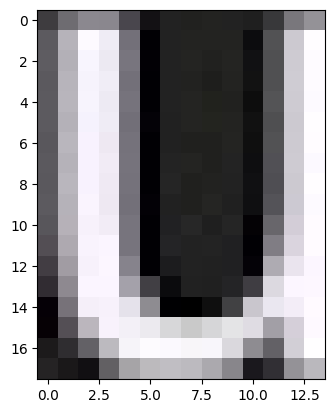

In [96]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


#-----------------------------------------------------------------------------------------------------------
filename = "/Users/matsuurakenshin/WorkSpace/development/txtreader/txtreader_Mk-II/image_file_name.txt"
imageslist = []
import os
if os.path.exists(filename) == False:
    with open("image_file_name.txt","w") as f:
        f.write("image_file_name")

imagenamefile = "/Users/matsuurakenshin/WorkSpace/development/txtreader/txtreader_Mk-II/image_file_name.txt"
if os.path.exists(imagenamefile) == True:
    with open(imagenamefile,"r") as f:
        for line in f:
            line = line.strip()
            if line != "image_file_name":
                if os.path.exists(line) == True:
                    imageslist.append(str(line.strip()))
                else:
                    print(f'image_file : "{line}" は存在しません。')


#-----------------------------------------------------------------------------------------------------------


def removal_background(color_image,RGB,kyoyou): #写真のNumPy配列を渡すと戻り値として背景を１とし、それ以外を0に置き換えた配列が戻ってくる。
    background_color = np.array(RGB)

    code0list = np.ones((color_image.shape[0]*color_image.shape[1],1), dtype='i1') #一旦0で埋める

    sa = np.abs(background_color - color_image)
    sa = sa.reshape(color_image.shape[0]*color_image.shape[1],3) #1ピクセル毎に背景色RGBと写真のRGBの差の絶対値の集合値を算出する為、配列を縦一列、列数３にする。
    text = np.array(np.where((np.sum(sa,axis=1)) > kyoyou)[0]) #背景色判定の許容値を超えた場合文字判定。

    code0list[text, 0] = np.array(0) #code0listに文字判定の場所を再代入。
    code0list = code0list.reshape(color_image.shape[0],color_image.shape[1]) #写真の比率にリサイズ。

    return code0list


def image_removal_background(imagename,RGB,kyoyou):
    #image = Image.open(imagename)
    image = cv2.cvtColor(cv2.imread(imagename),cv2.COLOR_BGR2RGB)
    color_image = np.array(image)

    dataslist = {}
    dataslist["image"] = image
    dataslist["RGB"] = RGB
    dataslist["kyoyou"] = kyoyou

    code0list = removal_background(color_image,RGB,kyoyou)


    with open("coode0list_printfile.txt","w") as f:
        for y in range(code0list.shape[0]):
            txt = ""
            for x in range(code0list.shape[1]):
                txt = txt + str(code0list[y,x])
            f.write(txt + "\n")

    dataslist["code0list"] = code0list

    return dataslist


#-----------------------------------------------------------------------------------------------------------

import copy

def seach_txtposition(dataslist, Airauto):
    code0list = dataslist["code0list"]
    xlen = code0list.shape[1]

    seach = "background"
    txt_sfy = []

    for y in range(int(code0list.shape[0])):

        if np.sum(code0list[y,:]) != xlen:
            if seach == "background":
                seach = "txt"
                txt_sfy.append([y, ""])

        else:
            if seach == "txt":
                seach = "background"
                txt_sfy[-1][1] = y-1

    seach = "background"
    linetxts_sfyx = []
    Airlist = []
    Airnum,Aircount,txtlen = 0,0,0
    #Aircount,deviation = 1,0

    for line in range(len(txt_sfy)):
        txt_sfyx = []

        for x in range(int(code0list.shape[1])):

            if np.sum(code0list[txt_sfy[line][0]:txt_sfy[line][1],x]) != txt_sfy[line][1]-txt_sfy[line][0]:
                if seach == "background":
                    seach = "txt"
                    txt_sfyx.append( [x , ""] )

            else:
                if seach == "txt":
                    seach = "background"
                    txt_sfyx[-1][1] = x-1

                    if Airauto == "auto":
                        if len(txt_sfyx) >= 2:
                            if abs(Airnum - (txt_sfyx[-1][0] - txt_sfyx[-2][1])) <= 1:
                                if Aircount >= 3:
                                    Airlist.append(txtlen)
                                Aircount += 1
                            else:
                                Airnum = txt_sfyx[-1][0] - txt_sfyx[-2][1]
                                txtlen = txt_sfyx[-1][1] - txt_sfyx[-2][1]
                                Aircount,deviation = 1,0


        linetxts_sfyx.append([txt_sfy[line],txt_sfyx])

    Airlinetxts_sfyx = copy.deepcopy(linetxts_sfyx)

    if Airauto == "auto":
        Airlen = int(sum(Airlist)/len(Airlist))
        print(Airlist,Airlen)
    else:
        Airlen = Airauto

    for line in range(len(linetxts_sfyx)):
        count = 0
        for txtline in range(len(linetxts_sfyx[line][1])-1):
            if linetxts_sfyx[line][1][txtline+1][0] - linetxts_sfyx[line][1][txtline][1] > Airlen:

                Airlinetxts_sfyx[line][1].insert(txtline + count + 1,"Air")
                count += 1

    dataslist["linetxts_sfyx"] = Airlinetxts_sfyx
    return dataslist


#-----------------------------------------------------------------------------------------------------------

def readtxt_imshow(dataslist):
    color_image = np.array(dataslist['image'])
    linetxts_sfyx = dataslist["linetxts_sfyx"]

    for line in linetxts_sfyx:
        a = line[0][0]
        b = line[0][1]
        color_image[a,:] = np.array([0,150,150])
        color_image[b,:] = np.array([0,150,150])
        for txt in range(len(line[1])):
            if line[1][txt] != "Air":
                color_image[a:b,line[1][txt][1]] = np.array([0,150,0])
                color_image[a:b,line[1][txt][0]] = np.array([0,150,0])
            else:
                color_image[a:b,line[1][txt-1][1]+5] = np.array([255,0,0])
                color_image[a:b,line[1][txt+1][0]-5] = np.array([255,0,0])

    return color_image


#-----------------------------------------------------------------------------------------------------------

def txtdatas_insert(dataslist):
    color_image = np.array(dataslist["image"])
    code0list = dataslist["code0list"]

    #plt.imshow(color_image[:100,:100])
    linetxts_sfyx = dataslist["linetxts_sfyx"]
    Alltxtimages,txtimages = [],[]
    Alltxtdatas,txtdatas = [],[]


    for line in range(len(linetxts_sfyx)):
        placey = linetxts_sfyx[line][0]
        for txt in range(len(linetxts_sfyx[line][1])):
            if linetxts_sfyx[line][1][txt] != "Air":

                placex = linetxts_sfyx[line][1][txt]
                leny = placey[1] - placey[0]
                lenx = placex[1] - placex[0]

                txtimage = color_image[placey[0]:placey[1],placex[0]:placex[1]]
                txtdata = code0list[placey[0]:placey[1],placex[0]:placex[1]]

                for top in range(leny):
                    if np.sum(txtdata[top,:]) != lenx:
                        txtimage = txtimage[top:,:]
                        txtdata = txtdata[top:,:]
                        break

                resizeleny = np.shape(txtdata)[0]

                for lower in range(resizeleny):
                    if np.sum(txtdata[resizeleny-lower -1 ,:]) != lenx:
                        txtimage = txtimage[:resizeleny-lower,:]
                        txtdata = txtdata[:resizeleny-lower,:]
                        break

            else:
                txtimage = ""
                txtdata = ""

            txtimages.append(txtimage)
            txtdatas.append(txtdata)

        Alltxtimages.append(txtimages)
        Alltxtdatas.append(txtdatas)

        txtimages = []
        txtdatas = []

    dataslist["Alltxtimages"] = Alltxtimages
    dataslist["Alltxtdatas"] = Alltxtdatas
    return dataslist


#-----------------------------------------------------------------------------------------------------------

def print_textdatas(dataslist,writefilename):
    txtdatas = dataslist["Alltxtdatas"]
    lineMaxlenx,lineMaxleny = [],[]

#    with open(writefilename,"w") as f:

    Maxlenx = 0
    for line in range(len(txtdatas)):
        lineMaxleny.append(0)
        if len(txtdatas[line]) > Maxlenx:
            Maxlenx = len(txtdatas[line])
        txtline = txtdatas[line]
        for txt in range(len(txtline)):
            if len(txtline[txt]) != 0:
                if np.shape(txtline[txt])[0] > lineMaxleny[line]:
                    lineMaxleny[line] = np.shape(txtline[txt])[0]


    for nouse in range(Maxlenx):
        lineMaxlenx.append(0)

    for line in range(len(txtdatas)):
        txtline = txtdatas[line]
        for txt in range(len(txtline)):
            if len(txtline[txt]) != 0:
                if np.shape(txtline[txt])[1] > lineMaxlenx[txt]:
                    lineMaxlenx[txt] = np.shape(txtline[txt])[1]


    with open(writefilename,"w") as f:
        for line in range(len(txtdatas)):
            printlist = []
            txtline = txtdatas[line]
            thislineMaxY = lineMaxleny[line]

            for nouse in range(thislineMaxY):
                printlist.append("")

            for txt in range(len(txtline)):
                thislineMaxX = lineMaxlenx[txt]

                Textlen = thislineMaxX *2 +1

                if len(txtline[txt]) != 0:
                    ylen,xlen = np.shape(txtline[txt])
                    Airy = thislineMaxY - ylen
                    Airx = (thislineMaxX - xlen)*2

                    y = 0

                    for nouse in range(Airy//2 + Airy%2):
                        printlist[y] = (f"{printlist[y]}{Textlen * ' '} | ")
                        y += 1

                    for txty in txtline[txt]:
                        printlist[y] = (f"{printlist[y]}{(Airx//2 + Airx%2)*' '}{txty}{(Airx//2)*' '} | ")
                        y += 1
                    for nouse in range(Airy//2):
                        printlist[y] = (f"{printlist[y]}{Textlen * ' '} | ")
                        y += 1


                else:
                    y = 0
                    for nouse in range(thislineMaxY):
                        printlist[y] = (f"{printlist[y]}{Textlen * ' '} | ")
                        y += 1

            printlen = len(printlist[0][:894])

            if line != 0:
                b = printlen
                if a > b:
                    f.write(f"\n{a*'-'}\n\n")
                else:
                    f.write(f"\n{b*'-'}\n\n")
                a = printlen

            else:
                f.write(f"{printlen*'-'}\n\n")
                a = printlen
            

            for printline in printlist:
                f.write("| "+printline[:894]+ "\n")

        f.write(f"\n{len(printline[:894])*'-'}")


#===========================================================================================================

import pickle


# seach_textdatas
with open('/Users/matsuurakenshin/WorkSpace/development/txtreader/txtreader_Mk-II/Save_retest.pickle', mode='br') as fi:
  seach_textdatas,retest = pickle.load(fi)


#===========================================================================================================


def seach_txt(txtimage,seach_textdatas,kyoyou,dataslist,txt):
    rgb = dataslist["RGB"]
    kyoyoucolor = dataslist["kyoyou"]
    hiritu = np.shape(txtimage)[1]/np.shape(txtimage)[0]        
    Max = 0
    anserline = ""
    for line in range(len(seach_textdatas)):

        if abs(seach_textdatas[line][0] - hiritu) < kyoyou:
            set_image = removal_background(cv2.resize(txtimage,dsize=(seach_textdatas[line][1][1],seach_textdatas[line][1][0])),rgb,kyoyoucolor)
            #print(set_image)
            syougouritu = np.count_nonzero(set_image[seach_textdatas[line][2]] == 0) / np.shape(seach_textdatas[line][2])[1]
            
            if syougouritu > Max:
                if syougouritu > 0.9:
                    anserline = line
                    break
                Max = syougouritu
                anserline = line


    #print(f'▶️▶️ {anserline} :{str(Max * 100)}%')
    Min = 100

    if anserline == "":
        return "_?_"

    for line in retest[anserline]:

        set_image = removal_background(cv2.resize(txtimage,dsize=(seach_textdatas[line][1][1],seach_textdatas[line][1][0])),rgb,kyoyoucolor)

        syougouritu = np.count_nonzero(set_image[seach_textdatas[line][2]] == 0) / np.shape(seach_textdatas[line][2])[1]

        Pi0 = np.count_nonzero(set_image == 0)
        Sa0 = np.shape(seach_textdatas[line][2])[1]
        Tr = np.count_nonzero(set_image[seach_textdatas[line][2]] == 0)

        False0num = Pi0 - Tr + Sa0 - Tr

        False0num = False0num / (seach_textdatas[line][1][1] * seach_textdatas[line][1][0])

        if txt != "":
            print(f"{seach_textdatas[line][3]}: Pi0 {Pi0}, Sa0 {Sa0} , Tr {Tr}")
        
        if txt != "None" and seach_textdatas[line][3] == txt:
            print(f"\n ▶️ {seach_textdatas[anserline][3]}\n ▶️ 合致率 :{syougouritu * 100}%\n ▶️ 不合致率 :{False0num * 100}%")

        if False0num < Min:
            Min = False0num
            anserline = line



    return seach_textdatas[anserline][3]


#===========================================================================================================

for imagename in imageslist:

    if imageslist[0] == "/Users/matsuurakenshin/WorkSpace/development/txtreader/txtreader_Mk-II/textdata.jpeg":
        dataslist = image_removal_background(imagename,[36,36,36],180)
    else:
        dataslist = image_removal_background(imagename,[34,34,34],120)
        
    dataslist = seach_txtposition(dataslist,120)
    dataslist = txtdatas_insert(dataslist)

    print_textdatas(dataslist,"Alltextimages.text")
    txtimage = dataslist["Alltxtimages"]
    txtdata = dataslist["Alltxtdatas"]
    #plt.imshow(readtxt_imshow(dataslist))
    #plt.imshow(cv2.resize(txtimage[0][0],dsize=(10,30)))
    #print(txtdata[0][1])
    print_textdatas(dataslist,"textdataslist_printfile.txt")

#-----------------------------------------------------------------------------------------------------------

line,lennum = 0,7

txt = "u"

print(len(txtimage[line][lennum]))

if len(txtimage[line][lennum]) != 0:
    print(f"文字は ' {seach_txt(txtimage[line][lennum],seach_textdatas,0.15,dataslist,txt)} ' ですか？")
    #print(textdata[num])
    plt.imshow(txtimage[line][lennum])

else:
    print(f"文字は Air判定 です。")


In [91]:
a = np.array([0, 0, 0, 30, 10, 10, 20])


axis0 = 2
axis1 = len(a)
b = []

for line in range(axis1):
    for nouse in range(axis0):
        b.append([a[line],0,0])

#print(len(b),axis0,axis1*3)

image = dataslist['image']
imageshape = np.shape(image)
a = image.reshape(imageshape[0] * imageshape[1],3)



#print(a)

u, indices, inverse, counts = np.unique(a, axis=0, return_index=True, return_inverse=True, return_counts=True)
#print(u)
# [[ 0  0 10 30]
#  [20 20 10 10]]

print()

#print(indices)
# [1 0]

#print(a[indices])
# [[ 0  0 10 30]
#  [20 20 10 10]]

Max = np.amax(counts)
print(Max)
posishon = np.where(counts == Max)[0]
print(u[posishon])



437642
[[34 34 34]]


In [97]:
for line in txtimage:
    txtanser = ""
    for txt in line:
        if len(txt) != 0:
            #print(f"文字は ' {seach_txt(txt,seach_textdatas,0.15,dataslist,txt)} ' ですか？")
            
            txtanser = txtanser + seach_txt(txt,seach_textdatas,0.15,dataslist,"")
            #print(textdata[num])
            #plt.imshow(txtimage[line][lennum])

        else:
            print(f"文字は Air判定 です。")
    
    print(txtanser)

        

importnumpyasnp
importcv2
cap=cv2.VideoCaptUre(0)
while(TrDe):
b.b.#CoptUr+fram+_?_dy_?_fra++
bbbbret,frame=cap.read()
bbbq#OUropenotion&onthefna+e&o`ehone
bbbbgray=cv2.CvtColor(frame,cv2.CoLo_?_BGR2GRAY)
